# Correct cell type annotations

Corrections:
1. Pool 'monocyte-DC progenitor (MDP)' and 'common DC progenitor (CDP)' to 'common DC progenitor (CDP)'
2. Cluster 'monocyte-derived DC' into two clusters --> 1 put into 'classical monocyte', 2 throw out (low quality)
3. Throw out DC hybrids ('B cell-DC hybrid', 'neutrophil-DC hybrid')


Note:   
We also   
- need to decide in which coarse groups we put the new annotations (is rather obvious, but needs to be adjusted!)
- recompute the DC umap, progenitors umap, monocyte umap
- check colors of umaps


In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'april21'
DATA_VERSION_NEW = 'oct22' # NEW VERSION
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
import numpy as np
import itertools
import scipy as sci
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

## Load data

In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [4]:
adata.obs["level2_old"] = adata.obs["level2"]
adata.obs["level1_old"] = adata.obs["level1"]

## plot options

In [5]:
plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Correct common DC progenitor (CDP)

In [6]:
a = adata[adata.obs["level2"].isin(['common DC progenitor (CDP)', "monocyte-DC progenitor (MDP)"])].copy()
pd.crosstab(a.obs["level2_old"],a.obs["level1_old"])

level1_old,progenitors,dendritic cell
level2_old,,
monocyte-DC progenitor (MDP),160,0
common DC progenitor (CDP),0,219


In [7]:
adata.obs.loc[adata.obs["level2_old"]=="monocyte-DC progenitor (MDP)", "level1"] = 'dendritic cell'
adata.obs.loc[adata.obs["level2_old"]=="monocyte-DC progenitor (MDP)", "level2"] = 'common DC progenitor (CDP)'

In [8]:
a = adata[adata.obs["level2"].isin(['common DC progenitor (CDP)', "monocyte-DC progenitor (MDP)"])].copy()
pd.crosstab(a.obs["level2"],a.obs["level1"])

level1,dendritic cell
level2,
common DC progenitor (CDP),379


## Correct monocyte-derived DC

In [9]:
a_tmp = adata[adata.obs["level2_old"] == "monocyte-derived DC"].copy()

In [10]:
pd.crosstab(a_tmp.obs["level2_old"],a_tmp.obs["level1_old"])

level1_old,dendritic cell
level2_old,
monocyte-derived DC,489


In [11]:
sc.tl.pca(a_tmp)
sc.pp.neighbors(a_tmp)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [12]:
sc.tl.leiden(a_tmp,resolution=0.1)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


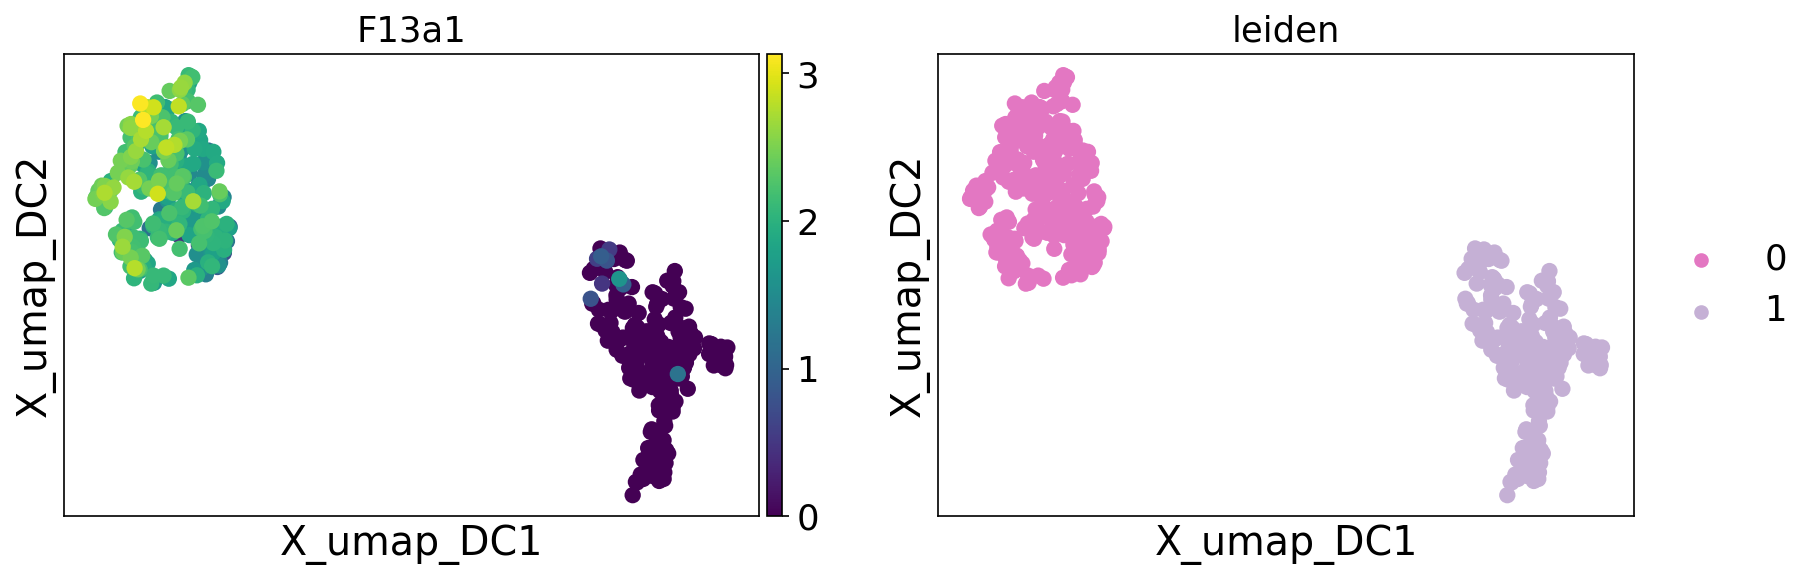

In [13]:
sc.pl.embedding(a_tmp,"X_umap_DC",color=["F13a1", "leiden"])

In [14]:
# Put leiden cluster 0 (F13a1+) into monocytes
adata.obs.loc[a_tmp[a_tmp.obs["leiden"] == "0"].obs_names, "level1"] = "monocyte"
adata.obs.loc[a_tmp[a_tmp.obs["leiden"] == "0"].obs_names, "level2"] = "classical monocyte"
# Throw out the only remaining monocyte-dervied DCs
adata = adata[~(adata.obs["level2"]=="monocyte-derived DC")]

In [15]:
a_tmp = adata[adata.obs_names.isin(a_tmp.obs_names)].copy()
pd.crosstab(a_tmp.obs["level2"],a_tmp.obs["level1"])

level1,monocyte
level2,
classical monocyte,257


# Throw out DC hybrids ('B cell-DC hybrid', 'neutrophil-DC hybrid')

In [16]:
adata = adata[~adata.obs["level2"].isin(['B cell-DC hybrid', 'neutrophil-DC hybrid'])]

### Remove unused categories

we adjust the common DC progenitor (CDP) color since it's to close to DC1

In [17]:
tmp_idx = adata.obs["level2"].cat.categories.tolist().index("common DC progenitor (CDP)")
adata.uns["level2_colors"][tmp_idx] = '#CF2917'

In [17]:
adata.obs["level1"] = adata.obs["level1"].cat.remove_unused_categories()
adata.obs["level2"] = adata.obs["level2"].cat.remove_unused_categories()

Trying to set attribute `.obs` of view, copying.


In [19]:
print(len(adata.obs["level1"].unique()))
print(len(adata.uns["level1_colors"]))
print(len(adata.obs["level2"].unique()))
print(len(adata.uns["level2_colors"]))

17
17
50
50


ok. numbers of colors already work, seems like adata understands removing the categories. wow

#### Recompute umaps where necessary

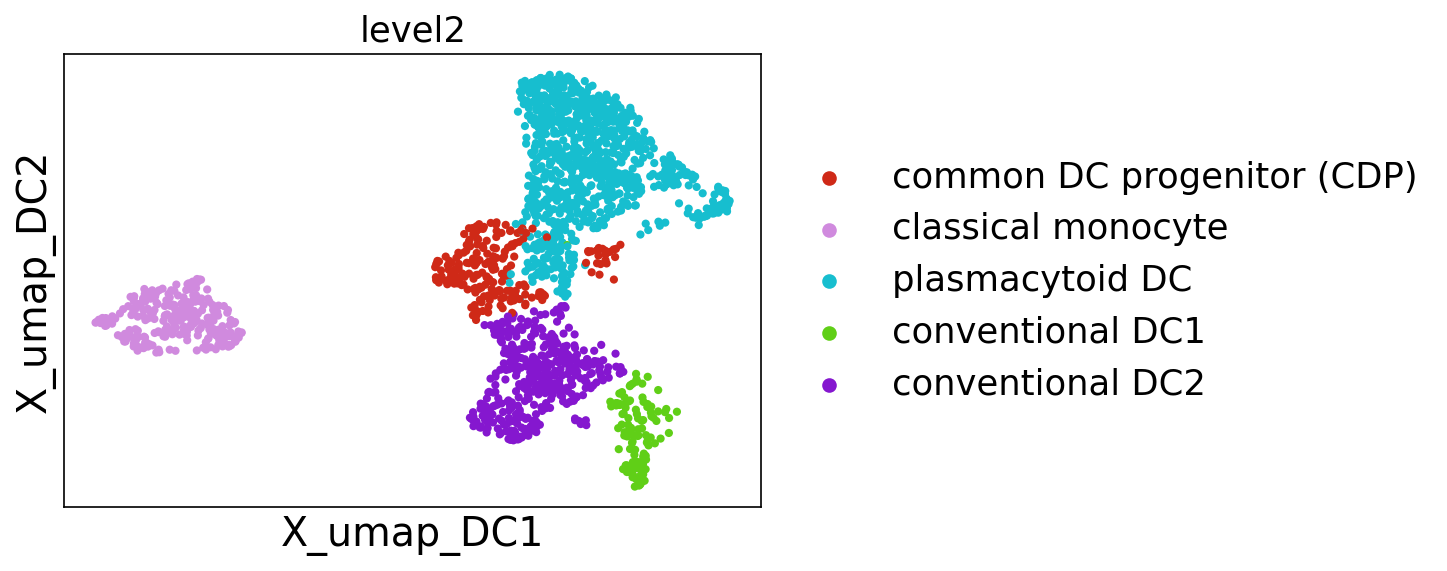

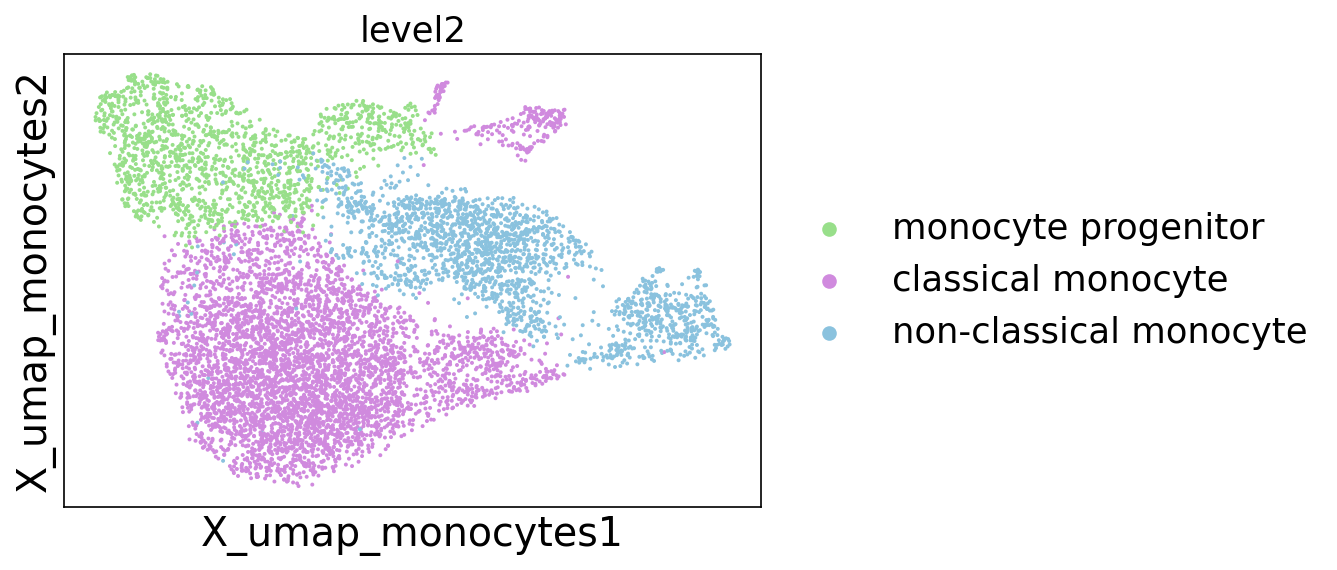

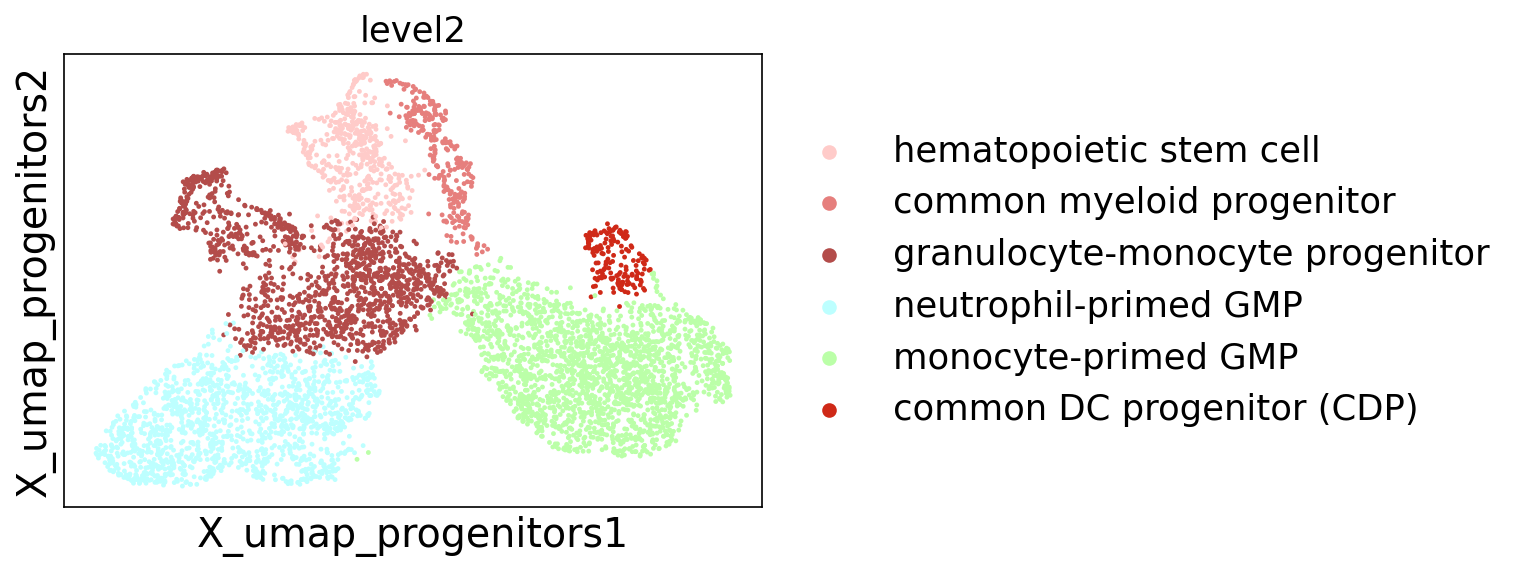

In [20]:
for u in ['X_umap_DC', 'X_umap_monocytes', 'X_umap_progenitors']:
    a = adata[~np.any(np.isnan(adata.obsm[u]),axis=1)].copy()
    sc.pl.embedding(a,u,color="level2")

In [21]:
def plot_subset_umap(adata,group,**kwargs):
    a = adata[~np.isnan(adata.obsm[f'X_umap_{group}']).any(axis=1)]
    sc.pl.embedding(basis=f'X_umap_{group}', adata=a,**kwargs)

def clean_for_umap(adata,verbose=True):
    if 'neighbors' in adata.uns: 
        del adata.uns['neighbors']
        if verbose: print("Deleted adata.uns['neighbors']")
    if 'pca' in adata.uns: 
        del adata.uns['pca']
        if verbose: print("Deleted adata.uns['pca']")
    if 'X_pca' in adata.obsm: 
        del adata.obsm['X_pca']
        if verbose: print("Deleted adata.obsm['X_pca']")
    if 'X_umap' in adata.obsm: 
        del adata.obsm['X_umap']
        if verbose: print("Deleted adata.obsm['X_umap']")
    if 'PCs' in adata.varm: 
        del adata.varm['PCs']
        if verbose: print("Deleted adata.varm['PCs']")
    if 'connectivities' in adata.obsp: 
        del adata.obsp['connectivities']
        if verbose: print("Deleted adata.obsp['connectivities']")
    if 'distances' in adata.obsp: 
        del adata.obsp['distances']
        if verbose: print("Deleted adata.obsp['distances']")

In [22]:
umap_groups = {
    #'NKT' : ['T cell','NK cell','NK-T cell',],
    #'B cells' : ['B cell',],
    #'basophil' : ['basophil',],
    'DC' : ['dendritic cell',],
    #'erythroid' : ['erythroid cell','erythroid precursor',],
    #'macrophage' : ['macrophage', 'microglia',],
    'monocytes' : ['monocyte',],
    'progenitors' : ['progenitors',],
    #'neutrophils' : ['neutrophil',],   
    #'structural cells' : ['structural cell',],
    #'brain cells' : ['brain cell'],
    #'other' : ['innate lymphoid cell','megakaryocyte',]    
}  

#adata.uns['umap_groups'] = umap_groups

sc.settings.verbosity = 0
from tqdm.notebook import tqdm
for group, cts in tqdm(umap_groups.items()): # {g:cs for g,cs in umap_groups.items() if f'X_umap_{g}' not in adata.obsm}
    a = adata[adata.obs['level1'].isin(cts)].copy()
    clean_for_umap(a,verbose=False)
    sc.tl.pca(a)
    sc.pp.neighbors(a)
    sc.tl.umap(a)
    # assign umap coordinates to adata
    adata.obsm[f'X_umap_{group}'] = np.empty((adata.n_obs,2,))
    adata.obsm[f'X_umap_{group}'][:] = np.nan
    obs = [(o in a.obs_names) for o in adata.obs_names]
    obs_names = adata[obs].obs_names
    adata.obsm[f'X_umap_{group}'][obs,:] = a[obs_names].obsm['X_umap']
sc.settings.verbosity = 3

  0%|          | 0/3 [00:00<?, ?it/s]

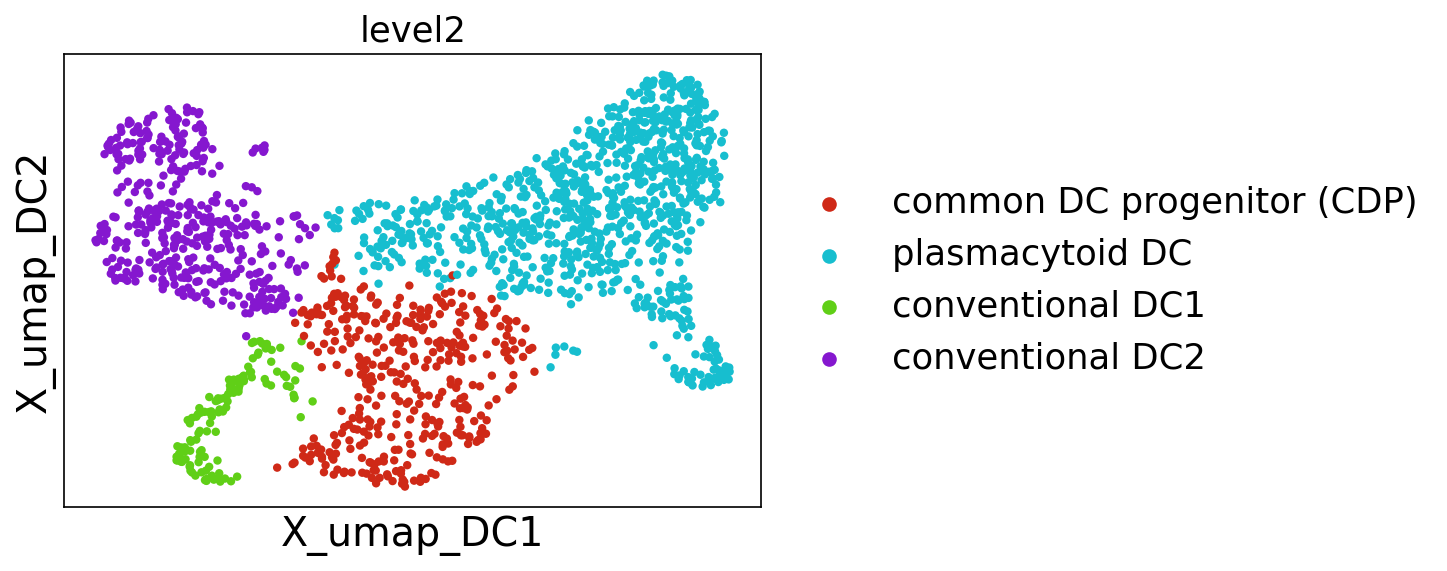

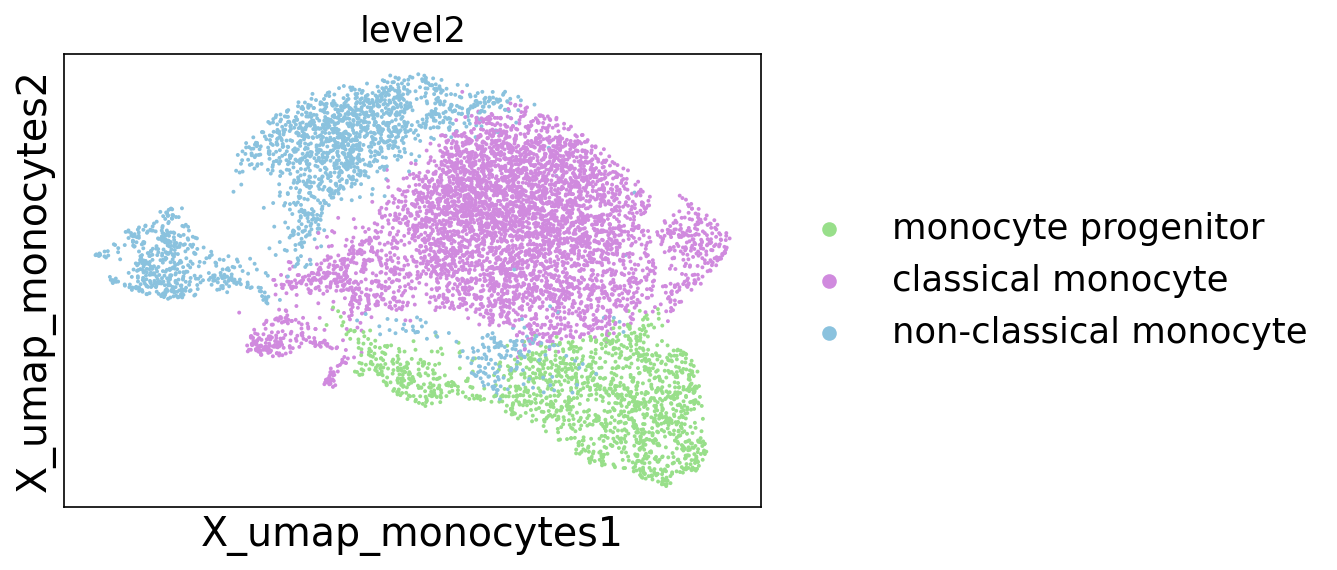

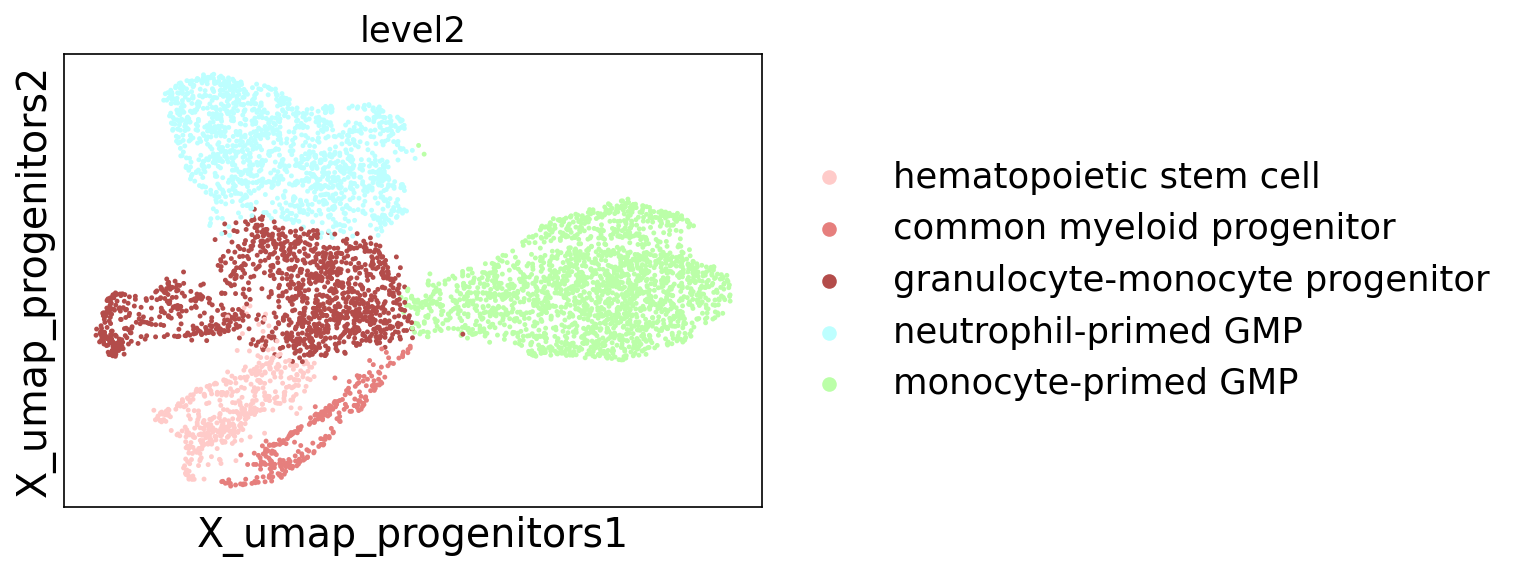

In [23]:
for u in ['X_umap_DC', 'X_umap_monocytes', 'X_umap_progenitors']:
    a = adata[~np.any(np.isnan(adata.obsm[u]),axis=1)].copy()
    sc.pl.embedding(a,u,color="level2")

# Write new adata version

In [24]:
adata

AnnData object with n_obs × n_vars = 147082 × 17088
    obs: 'sample_id', 'batch', 'sample_name', 'region', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors', 'leiden', 'leiden_high_res', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'cell_types_old', 'annotated', 'cell_types', 'level2', 'level1', 'level2_old', 'level1_old'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'annotated_colors', 'cell_types_colors', 'condition_colors', "dendrogram_['leiden']", 'hvg', 'leiden', 'leiden_colors', 'leiden_high_res_colors', 'leiden_res_3_colors', 'leiden_res_4_colors', 'level1_colors', 'level2_colors', 'neighbors', 'pca', 'rank_genes_groups', 'region_colors', 'sample_name_colors', 'umap', 'umap_groups'
    obsm: 'X_pca', 'X_umap', 'X_umap_B cells', 'X_umap_DC', 'X_umap_NKT', 'X_umap_basophil', 'X_umap_brain cells', 'X_umap_erythroid', 'X_umap_macrophage', '

In [25]:
sc.pp.filter_genes(adata,min_cells=1)

In [26]:
sc.write(adata=adata, filename=DATA_DIR+f'cellxgene_{DATA_VERSION_NEW}{sham_str}_umaps.h5ad')

# Umaps for Naive

In [32]:
adata_naive = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_Naive_umaps.h5ad')

# Update the annotations also in Naive data

# First throw out cells that were filtered out
adata_naive = adata_naive[adata_naive.obs_names.isin(adata.obs_names)]

# Transfer annotations
adata_naive.obs["level1"] = adata.obs.loc[adata_naive.obs_names, "level1"]
adata_naive.obs["level2"] = adata.obs.loc[adata_naive.obs_names, "level2"]

adata_naive.obs["level1"] = adata.obs["level1"].cat.remove_unused_categories()
adata_naive.obs["level2"] = adata.obs["level2"].cat.remove_unused_categories()


## full set:
#clean_for_umap(adata,verbose=False)
#sc.tl.pca(adata)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

# subsets:

umap_groups = {
    #'NKT' : ['T cell','NK cell','NK-T cell',],
    #'B cells' : ['B cell',],
    #'basophil' : ['basophil',],
    'DC' : ['dendritic cell',],
    #'erythroid' : ['erythroid cell','erythroid precursor',],
    #'macrophage' : ['macrophage', 'microglia',],
    'monocytes' : ['monocyte',],
    'progenitors' : ['progenitors',],
    #'neutrophils' : ['neutrophil',],   
    #'structural cells' : ['structural cell',],
    #'brain cells' : ['brain cell'],
    #'other' : ['innate lymphoid cell','megakaryocyte',]    
}  

#adata.uns['umap_groups'] = umap_groups

from tqdm.notebook import tqdm
for group, cts in tqdm(umap_groups.items()):
    a = adata_naive[adata_naive.obs['level1'].isin(cts)].copy()
    clean_for_umap(a,verbose=False)
    sc.tl.pca(a)
    sc.pp.neighbors(a)
    sc.tl.umap(a)
    # assign umap coordinates to adata
    adata_naive.obsm[f'X_umap_{group}'] = np.empty((adata_naive.n_obs,2,))
    adata_naive.obsm[f'X_umap_{group}'][:] = np.nan
    obs = [(o in a.obs_names) for o in adata_naive.obs_names]
    obs_names = adata_naive[obs].obs_names
    adata_naive.obsm[f'X_umap_{group}'][obs,:] = a[obs_names].obsm['X_umap']
sc.settings.verbosity = 3


for ct in adata_naive.obs["level2"].cat.categories:
    tmp_idx_naive = adata_naive.obs["level2"].cat.categories.tolist().index(ct)
    tmp_idx = adata.obs["level2"].cat.categories.tolist().index(ct)
    adata_naive.uns["level2_colors"][tmp_idx_naive] = adata.uns["level2_colors"][tmp_idx]

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/3 [00:00<?, ?it/s]

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['d

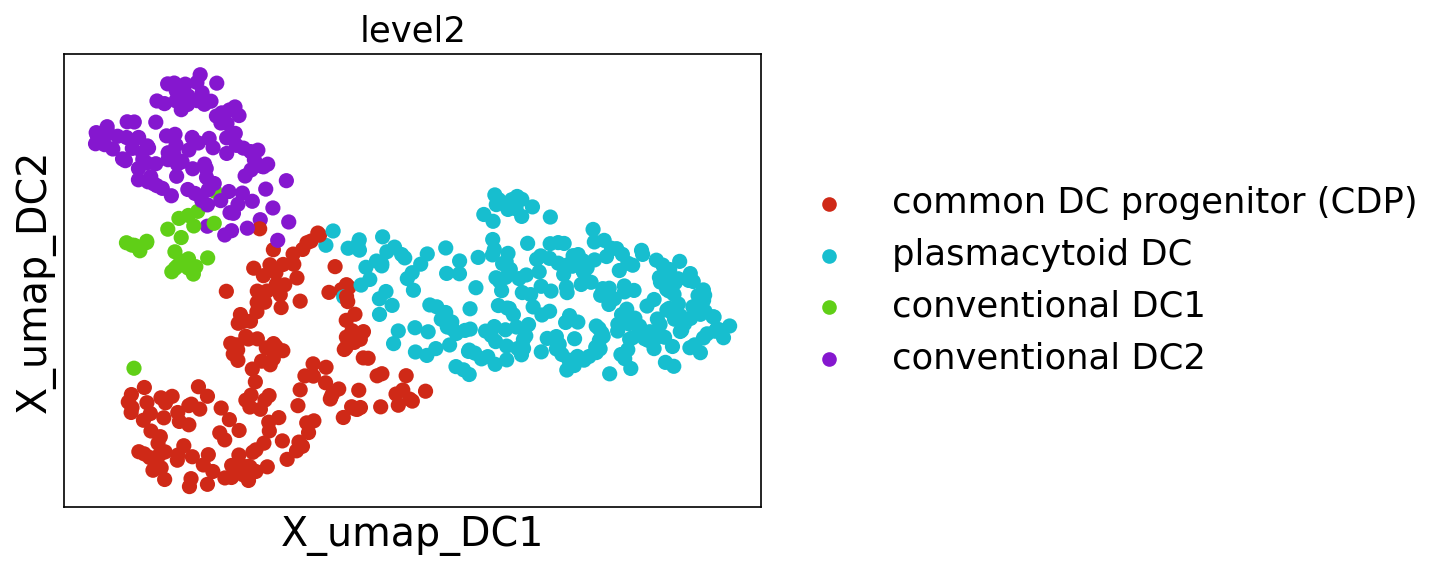

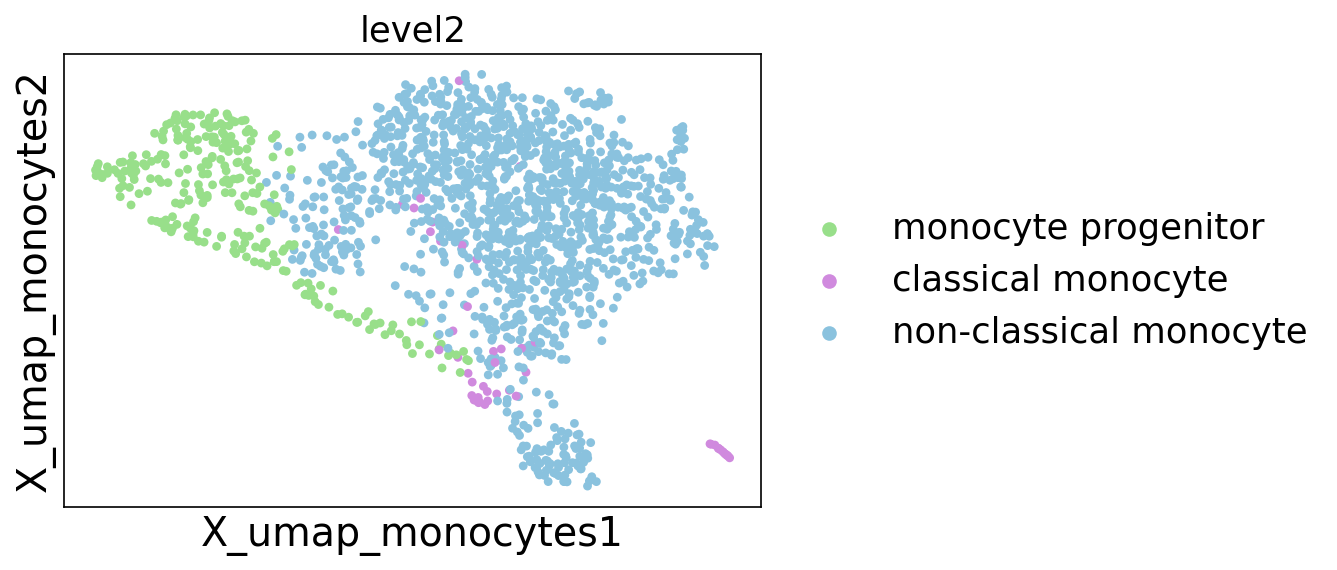

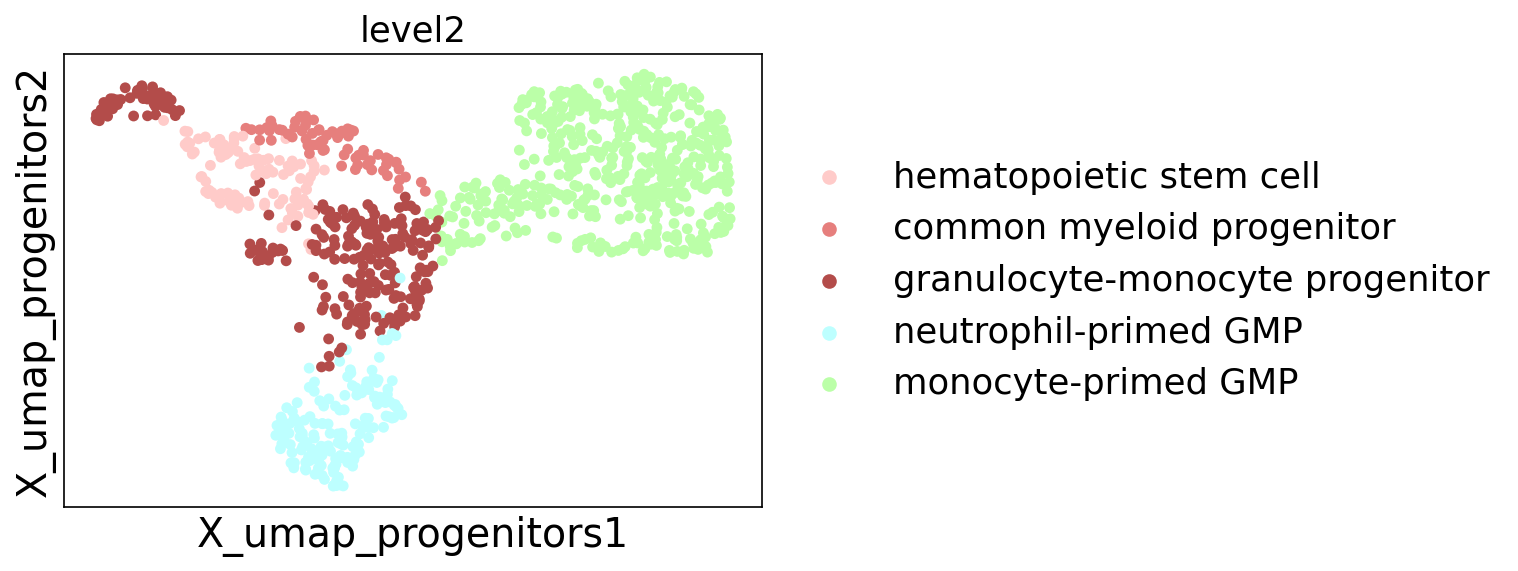

In [34]:
for u in ['X_umap_DC', 'X_umap_monocytes', 'X_umap_progenitors']:
    a = adata_naive[~np.any(np.isnan(adata_naive.obsm[u]),axis=1)].copy()
    sc.pl.embedding(a,u,color="level2")

In [35]:
sc.write(adata=adata, filename=DATA_DIR+f'cellxgene_{DATA_VERSION_NEW}{sham_str}_Naive_umaps.h5ad')